## Visualizing Original Geoparser - Total

We have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) with the original language model for finding the Name Entities for all Scottish Gazetteers, and select just the ones regarding with places. Later, once we have the locations entities, we have used the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('../../../results_Gazetteer/results_with_bb/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(place_label, place_freq, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.xlabel('Places', fontsize=15)
    plt.ylabel('Frequency of Places', fontsize=15)
    plt.xticks(index, place_label, rotation=80, fontsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    if plot_type == "resolved":
        plt.bar(index, place_freq, color='orange')
        plt.title('15 Places most mentioned using \n' +  ' the Original Geoparser across all Scottish Gazetteers')
    else:
        plt.bar(index, place_freq, color='coral')
        plt.title('15 Places most mentioned but not resolved using \n' +  'the Original Geoparser across all Scottish Gazetteers')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: geoparser_original
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [7]:
results=read_query_results('geoparser_original_total')

In [8]:
df_total= geresolution_dataframe(results)

year 1838
year 1806
year 1882
year 1828
year 1901
year 1883
year 1842
year 1846
year 1803
year 1825
year 1868
year 1848


In [9]:
df_total.head()

,Latitude,Longitude,Place,Page,Year
0,33.64836,-98.46944999999999,Scotland,Page2,1838
1,33.64836,-98.46944999999999,Scotland,Page4,1838
2,55.8666667,-4.25,GLASGOW,Page9,1838
3,55.95,-3.3725,EDINBURGH,Page9,1838
4,55.95,-3.3725,EDINBURGH,Page9,1838


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [10]:
df_total[["Place"]].count()

Place    392604
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [11]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

Creating a dataframe, df_not_resolved for futher exploration at the end of the notebook

In [12]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude     45826
Longitude    45826
Place        45826
Page         45826
Year         45826
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [13]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     346778
Longitude    346778
Place        346778
Page         346778
Year         346778
dtype: int64

## Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [14]:
df_resolved = df_total[df_total['Latitude'] != '']

In [15]:
df_resolved.count()

Latitude     346778
Longitude    346778
Place        346778
Page         346778
Year         346778
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [16]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [17]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#Displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,33.64836,-98.46944999999999,Scotland,Page2,1838
1,33.64836,-98.46944999999999,Scotland,Page4,1838
2,55.8666667,-4.25,Glasgow,Page9,1838
3,55.95,-3.3725,Edinburgh,Page9,1838
4,55.95,-3.3725,Edinburgh,Page9,1838
5,55.95,-3.3725,Edinburgh,Page9,1838
6,56,-4,Scotland,Page9,1838
7,41.7001006,-71.4995045,Warwick,Page9,1838
8,56,-4,Scotland,Page9,1838
9,-26.65,28.6,Balfour,Page9,1838


In [18]:
df_max_geolocations= df_capitalized[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)  
print(df_max_geolocations.count())
#displaying just the first 15 rows
df_max_geolocations.head(15)


Place    15916
count    15916
dtype: int64


,Place,count
13586,Scotland,9185
5061,Edinburgh,6626
6074,Glasgow,5850
7383,Inverness,3809
12578,Perthshire,3312
12567,Perth,3271
3077,Clyde,2947
34,Aberdeen,2574
14263,Stirling,2343
10765,Ord,2292


In [19]:
#Getting the 15 places (and their frequencies) most mentioned
place_label= df_max_geolocations['Place'].tolist()[0:15]
place_freq= df_max_geolocations['count'].tolist()[0:15]
    

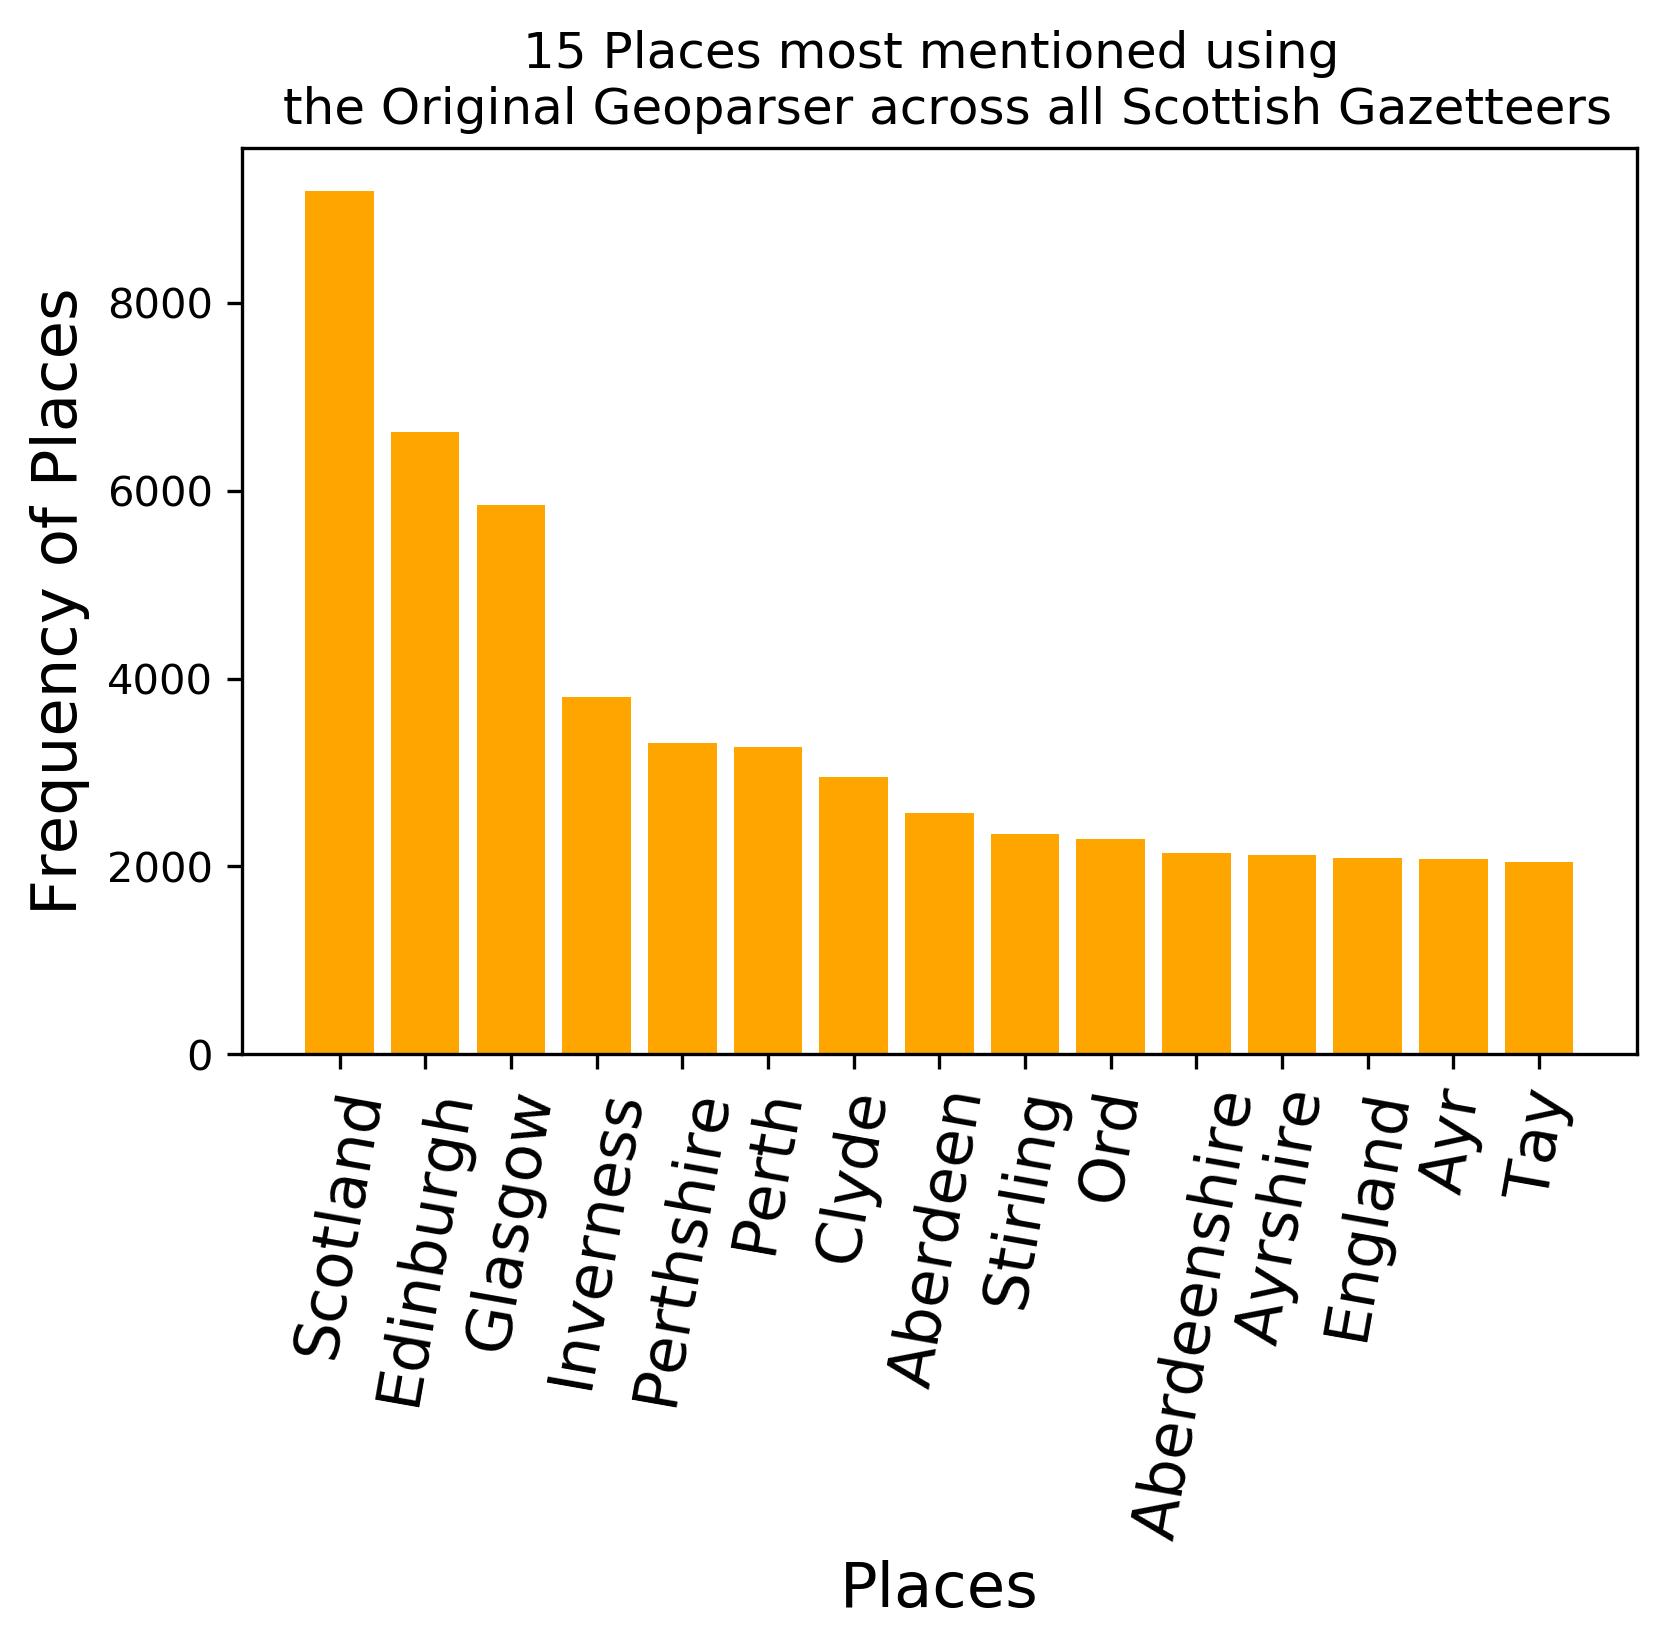

In [20]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq, plot_type='resolved')

## Exploring the locations not resolved

Places names - forcing all to lower case, and later capitalize them

In [21]:
df4 = df_not_resolved.copy()
df4['Place']=df_not_resolved['Place'].apply(str.lower)

In [22]:
df_not_res_cap= df4.copy()
df_not_res_cap['Place']=df4['Place'].apply(str.capitalize)


In [23]:
df_not_resolved_max = df_not_res_cap[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_not_resolved_max.count())
#displapying the first 15 rows
df_not_resolved_max.head(15)

Place    13822
count    13822
dtype: int64


,Place,count
4755,Edinburghshire,1014
375,Argyleshire,785
6001,Haddingtonshire,731
7568,Linlithgowshire,506
13223,Tyne,352
5498,German ocean,264
6585,Inverury,169
12122,Shotts,153
3519,Culdees,153
11659,Restalrig,150


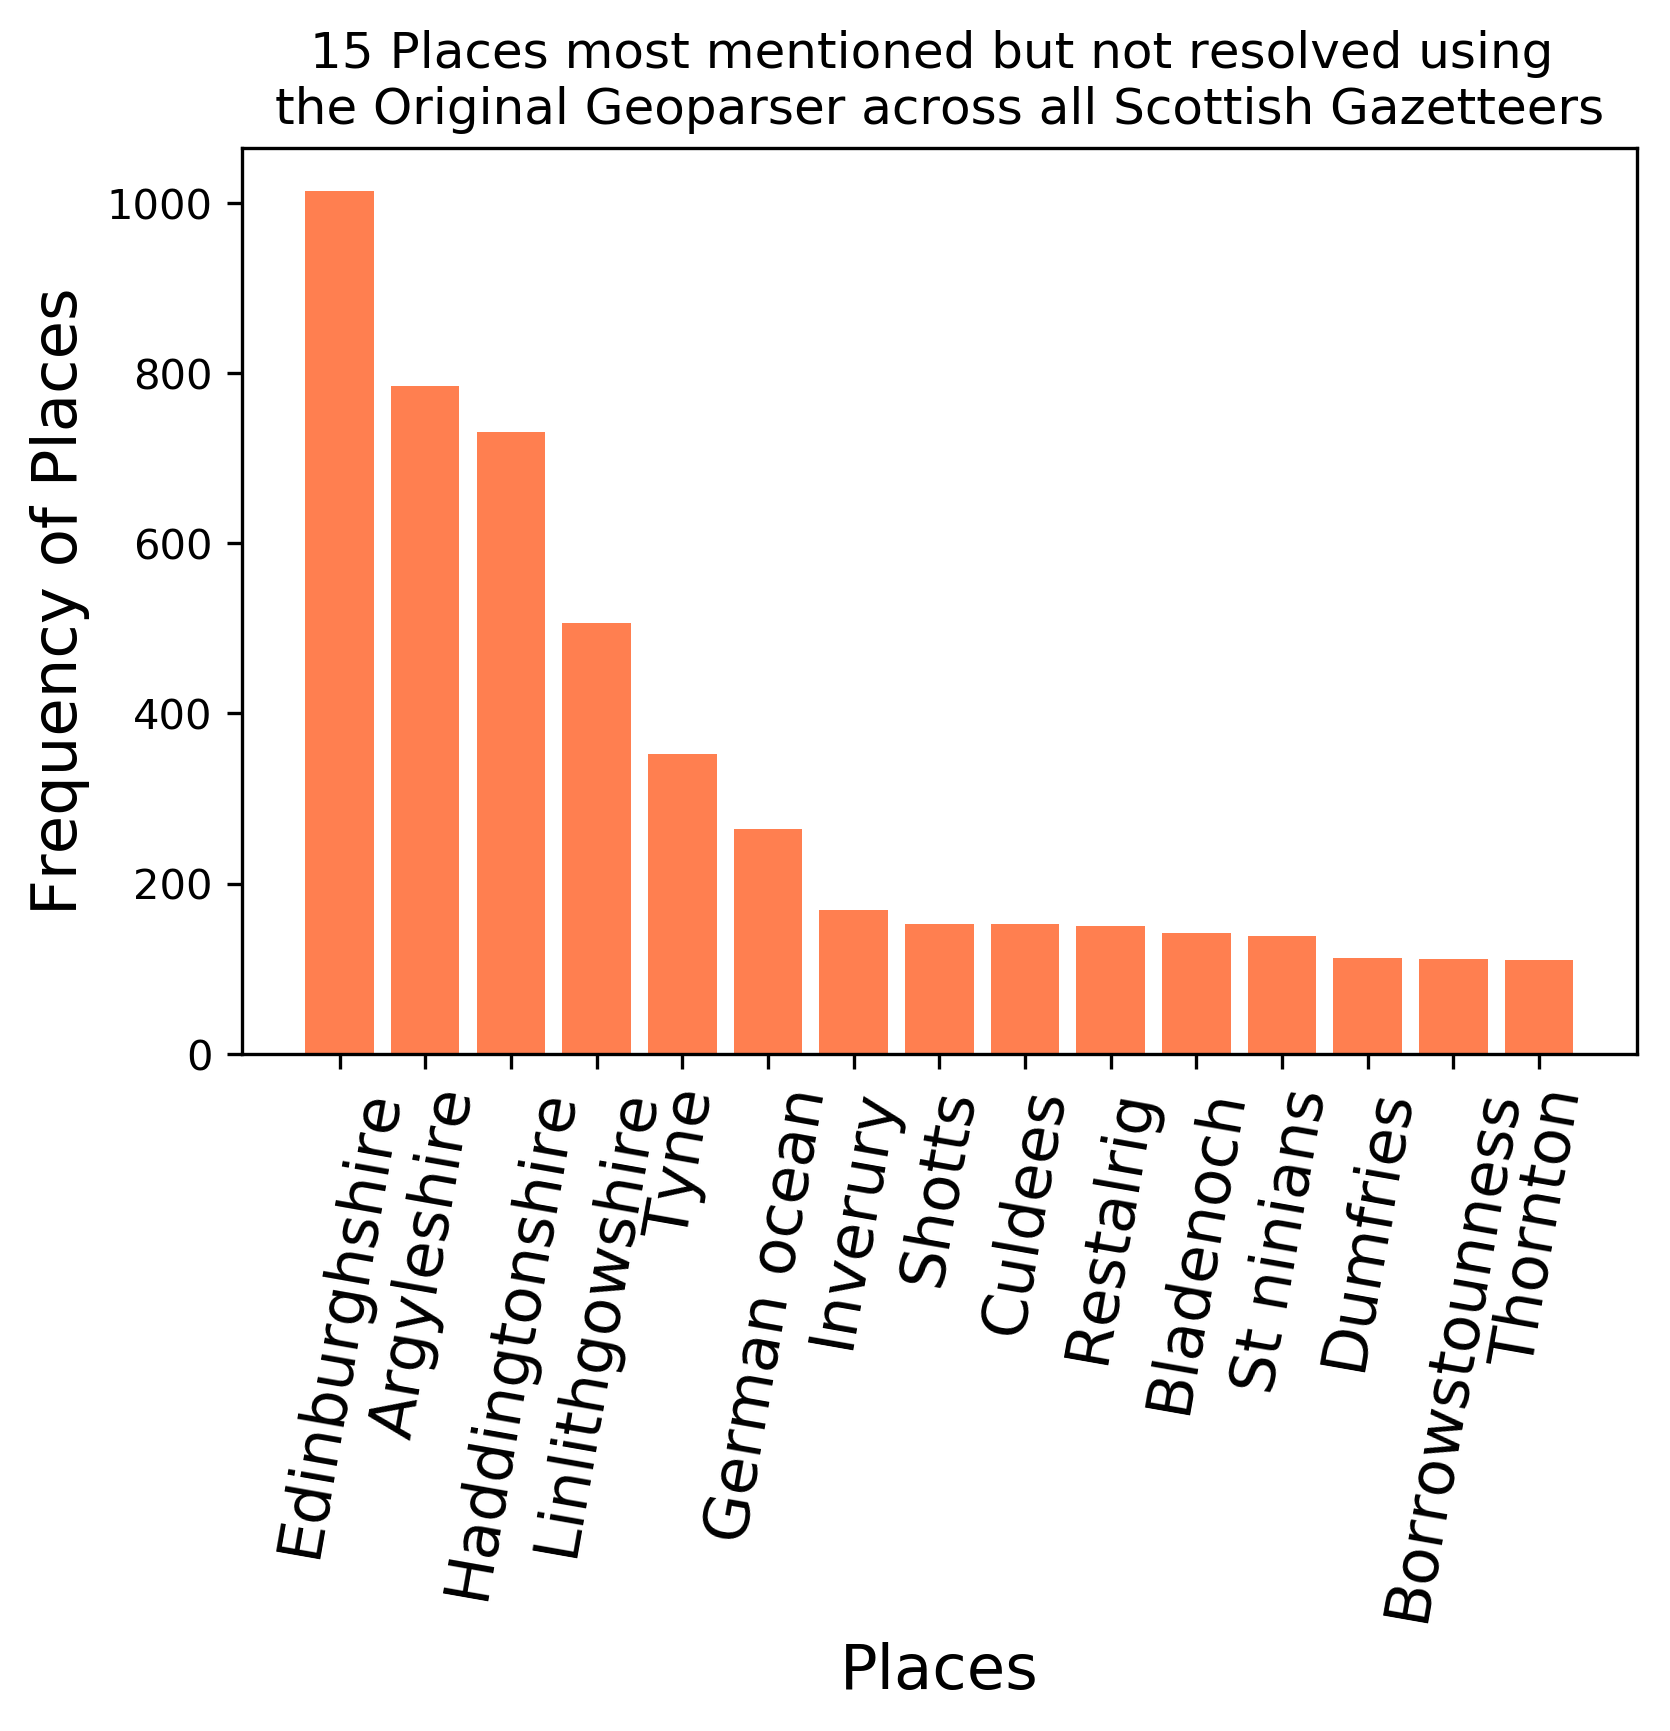

In [24]:
#Getting the 15 places (and their frequencies) most mentioned
place_label_not_resolved= df_not_resolved_max['Place'].tolist()[0:15]
place_freq_not_resolved= df_not_resolved_max['count'].tolist()[0:15]
plot_bar_places(place_label_not_resolved, place_freq_not_resolved, plot_type='not_resolved')